In [9]:
# Import Libraries 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

In [8]:
# Load Titanic dataset from Data Science Dojo GitHub
url='https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv'
df=pd.read_csv(url)
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [5]:
df.shape

(891, 12)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [10]:
# Missing values
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [11]:
# Handling of missing values
# 1. Create flags indicating where values are missing 

df['Age_imputed']=df['Age'].isna().astype(int)
df['Embraked_missing']=df['Embarked'].isna().astype(int) 

In [12]:
# 2. Impute Age with Median
median_age=df['Age'].median()
df['Age']=df['Age'].fillna(median_age)

In [13]:
# 3. Impute Embarked with most frequent value (mode)
mode_emb=df['Embarked'].mode()[0]
df['Embarked']=df['Embarked'].fillna(mode_emb)

In [14]:
# 4. Extract Deck from cabin 
df['Deck']=df['Cabin'].str.replace(r'(\W).*',r'\1',regex=True)
df['Deck']=df['Deck'].fillna('MISSING')
df.drop(columns=['Cabin'],inplace=True)

In [16]:
df['Deck']

0      MISSING
1          C85
2      MISSING
3         C123
4      MISSING
        ...   
886    MISSING
887        B42
888    MISSING
889       C148
890    MISSING
Name: Deck, Length: 891, dtype: object

In [18]:
# show summary of missing handling 
print('post-cleaning missing values :')
print(df[['Age_imputed','Embraked_missing']].sum())
df[['Age','Embarked','Deck']].head()

post-cleaning missing values :
Age_imputed         177
Embraked_missing      2
dtype: int64


,Age,Embarked,Deck
0,22.0,S,MISSING
1,38.0,C,C85
2,26.0,S,MISSING
3,35.0,S,C123
4,35.0,S,MISSING


In [22]:
# Impute Age using mean age per group (pclass,sex)
mean_ages = df.groupby(['Pclass', 'Sex'])['Age'].transform('mean')
df['Age']=df['Age'].fillna(mean_ages)

In [23]:
# show summary of missing handling 
print('post-cleaning missing values :')
print(df[['Age_imputed','Embraked_missing']].sum())
df[['Age','Embarked','Deck']].head()

post-cleaning missing values :
Age_imputed         177
Embraked_missing      2
dtype: int64


,Age,Embarked,Deck
0,22.0,S,MISSING
1,38.0,C,C85
2,26.0,S,MISSING
3,35.0,S,C123
4,35.0,S,MISSING


In [40]:
# import 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve


In [41]:
# We create robust features and make sure columns exist with the right types
# - FamilySize / IsAlone
# - Deck (from Cabin if missing)
# - Title (extracted from Name)
# - Treat Pclass as categorical (string)
# - Drop columns we don't use later (will be dropped right before modeling)

df = df.copy()

if 'FamilySize' not in df.columns:
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

if 'IsAlone' not in df.columns:
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

if 'Deck' not in df.columns:
    # If Cabin exists, take first letter; otherwise mark as MISSING
    if 'Cabin' in df.columns:
        deck = df['Cabin'].astype(str).str[0]
        deck = deck.where(deck.str.isalpha(), 'MISSING')
        df['Deck'] = deck.fillna('MISSING')
    else:
        df['Deck'] = 'MISSING'

# Extract Title from Name (rare titles grouped as 'Rare')
if 'Title' not in df.columns and 'Name' in df.columns:
    df['Title'] = df['Name'].str.extract(r',\s*([^\.]+)\.').iloc[:, 0]
    rare = df['Title'].value_counts()[df['Title'].value_counts() < 10].index
    df['Title'] = df['Title'].replace(rare, 'Rare')
    df['Title'] = df['Title'].fillna('Unknown')

# Make sure Pclass is treated as categorical
df['Pclass'] = df['Pclass'].astype(str)

In [42]:
# We split data and build feature lists dynamically (robust to missing columns)
target = 'Survived'

drop_cols = [c for c in ['PassengerId', 'Name', 'Ticket', 'Cabin'] if c in df.columns]
X = df.drop(columns=[target] + drop_cols)
y = df[target]

# Candidate lists
num_candidates = ['Age', 'Fare', 'SibSp', 'Parch', 'FamilySize']
cat_candidates = ['Sex', 'Pclass', 'Embarked', 'IsAlone', 'Deck', 'Title']

numeric_feats = [c for c in num_candidates if c in X.columns]
categorical_feats = [c for c in cat_candidates if c in X.columns]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [43]:
# We define a clean preprocessing pipeline and a logistic regression model
# - Numeric: median imputation + scaling (with_mean=False for sparse safety)
# - Categorical: most_frequent imputation + OneHotEncoder(handle_unknown='ignore')

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler(with_mean=False))
])

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipe, numeric_feats),
    ('cat', cat_pipe, categorical_feats)
])

full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=1000, solver='liblinear', random_state=42))
])

In [44]:
# We fit the pipeline, make predictions, and print standard metrics
full_pipeline.fit(X_train, y_train)

y_pred  = full_pipeline.predict(X_test)
y_proba = full_pipeline.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.88      0.87       110
           1       0.81      0.78      0.79        69

    accuracy                           0.84       179
   macro avg       0.84      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179

ROC-AUC: 0.8736495388669302


In [45]:
# We safely extract transformed feature names (works after fit)
# Prefer ColumnTransformer.get_feature_names_out; if not available, fall back to OHE names

try:
    feature_names = full_pipeline.named_steps['preprocessor'].get_feature_names_out()
except Exception:
    # Fallback: build names from parts if needed
    ohe = full_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['ohe']
    cat_names = ohe.get_feature_names_out(categorical_feats)
    feature_names = np.r_[numeric_feats, cat_names]

coefs = full_pipeline.named_steps['model'].coef_.ravel()
imp_df = pd.DataFrame({'feature': feature_names, 'coef': coefs})
imp_df['abs_coef'] = imp_df['coef'].abs()

# Show top 10 most influential features by absolute coefficient
top10 = imp_df.sort_values('abs_coef', ascending=False).head(10)
print(top10[['feature', 'coef']])

               feature      coef
147  cat__Title_Master  1.488976
5      cat__Sex_female  1.242986
150      cat__Title_Mr -0.995500
139  cat__Deck_MISSING -0.946514
118      cat__Deck_E25  0.827997
74       cat__Deck_C49 -0.797028
7        cat__Pclass_1  0.772896
153     cat__Title_Rev -0.764395
68      cat__Deck_C22  -0.755182
132      cat__Deck_E77 -0.754952


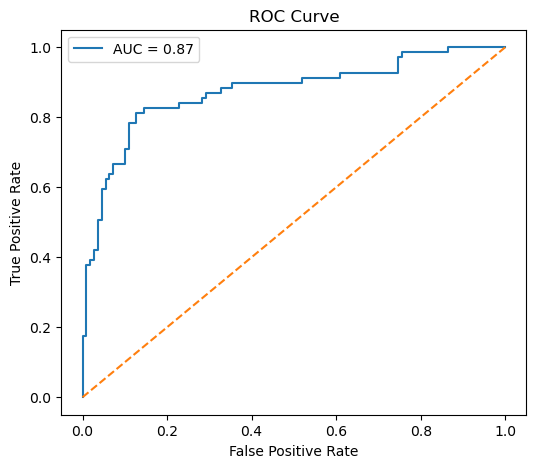

In [47]:
# We plot a simple ROC curve to visualize model discrimination
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.2f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.savefig('False , True Positive Rate',dpi=300,bbox_inches='tight')
plt.show()